# Industry sales for printing and writing paper
## January 1963 – December 1972

In [1]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

def invboxcox(y,lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))

Populating the interactive namespace from numpy and matplotlib


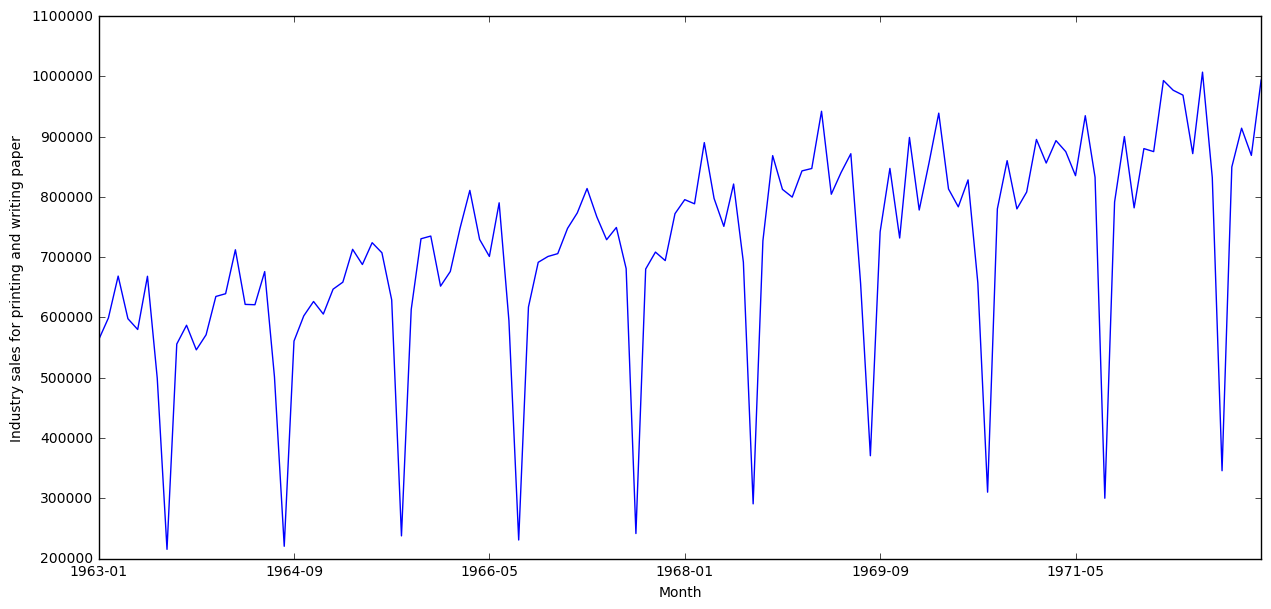

In [2]:
# reading data from csv file
paper_sales_data = pd.read_csv('industry-sales-for-printing-and-.csv', ';', index_col=['Month'], parse_dates=['Month'])
paper_sales_data.columns = ['sales']
paper_sales_data = paper_sales_data.drop(paper_sales_data.index[len(paper_sales_data)-1])

# and plotting it
paper_sales_data.sales = paper_sales_data.sales * 1000
plt.figure(figsize(15,7))
paper_sales_data.sales.plot()
plt.ylabel('Industry sales for printing and writing paper')
pylab.show()

Проверка стационарности и STL-декомпозиция ряда:

Критерий Дики-Фуллера: p=0.942338


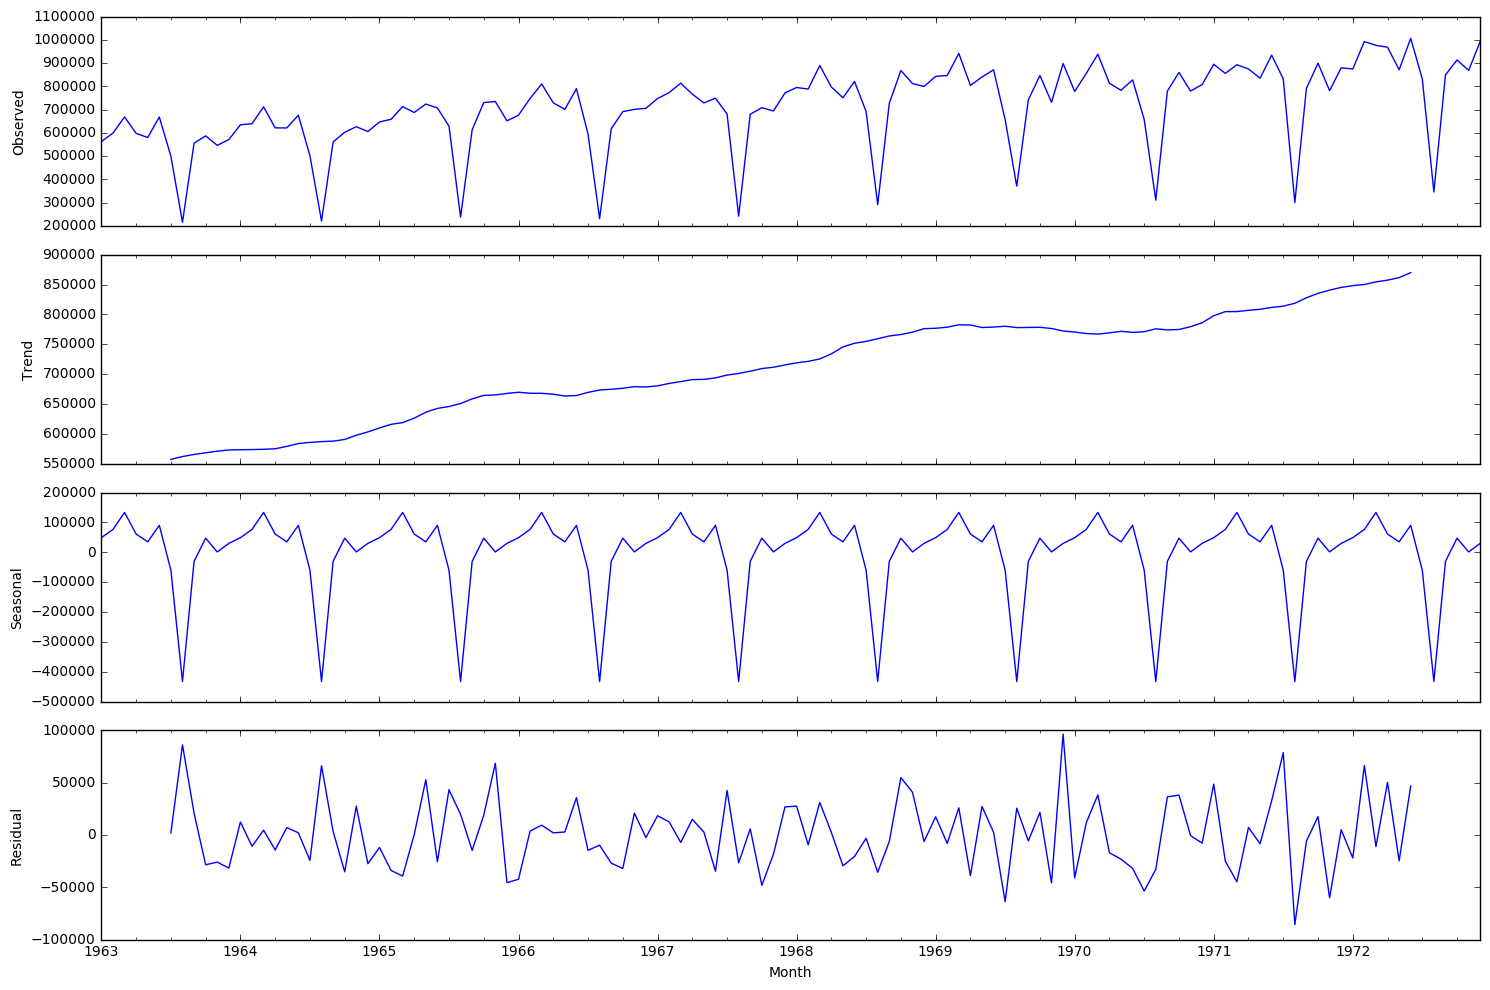

In [3]:
plt.figure(figsize(15,10))
paper_sales_data.reset_index(inplace=True)
paper_sales_data['Month'] = pd.to_datetime(paper_sales_data['Month'])
paper_sales_data = paper_sales_data.set_index('Month')
sm.tsa.seasonal_decompose(paper_sales_data.sales).plot()
print('Критерий Дики-Фуллера: p=%f' % sm.tsa.stattools.adfuller(paper_sales_data.sales)[1])

### Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 2.193636
Критерий Дики-Фуллера: p=0.993612


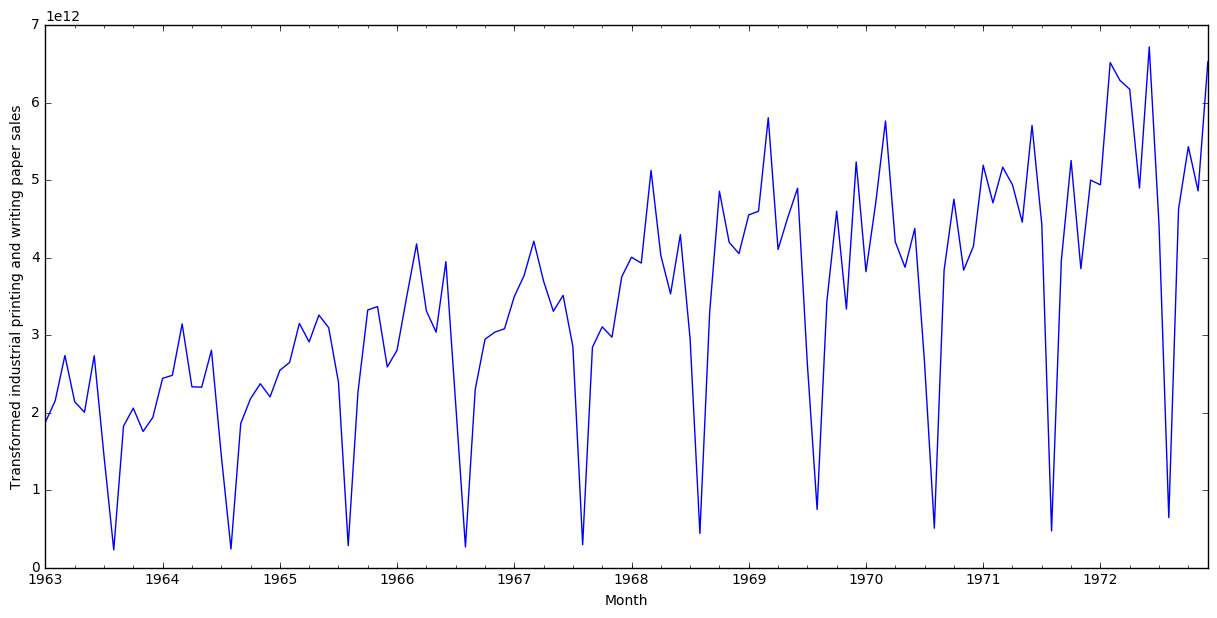

In [4]:
paper_sales_data['sales_box'], lmbda = stats.boxcox(paper_sales_data.sales)
plt.figure(figsize(15,7))
paper_sales_data.sales_box.plot()
plt.ylabel(u'Transformed industrial printing and writing paper sales')
print("Оптимальный параметр преобразования Бокса-Кокса: %f" % lmbda)
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box)[1])

### Стационарность

Критерий Дики-Фуллера отвергает гипотезу нестационарности, но визуально в данных виден тренд. Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.034364


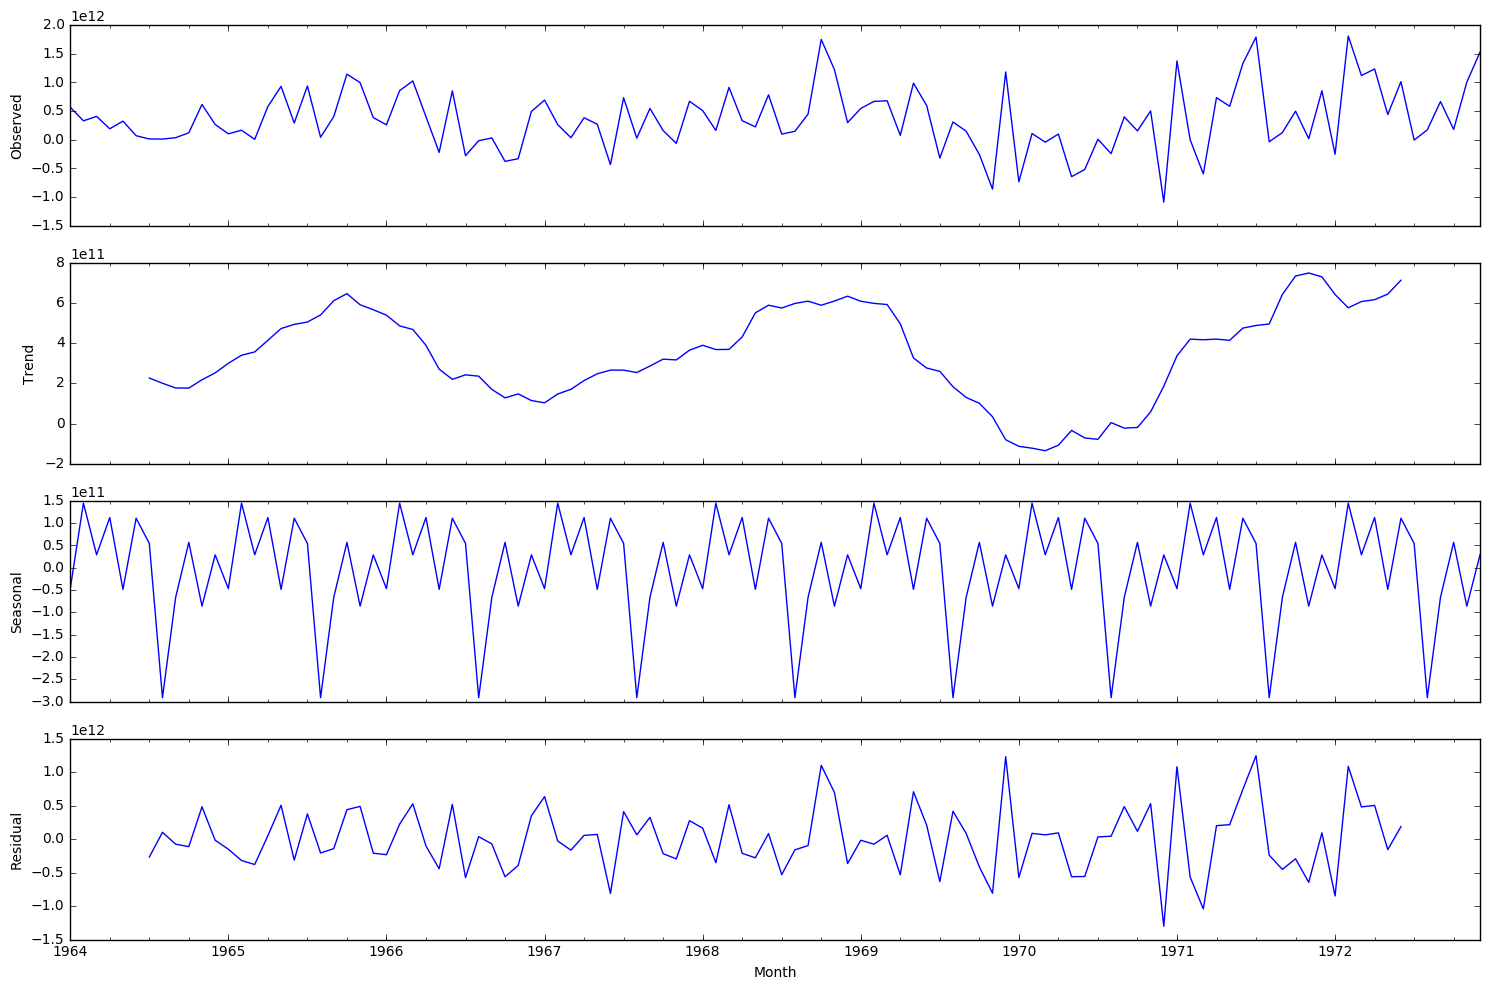

In [5]:
paper_sales_data['sales_box_diff'] = paper_sales_data.sales_box - paper_sales_data.sales_box.shift(12)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(paper_sales_data.sales_box_diff[12:]).plot()
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box_diff[12:])[1])

Критерий Дики-Фуллера не отвергает гипотезу нестационарности, и полностью избавиться от тренда не удалось. Попробуем добавить ещё обычное дифференцирование:

Критерий Дики-Фуллера: p=0.067125


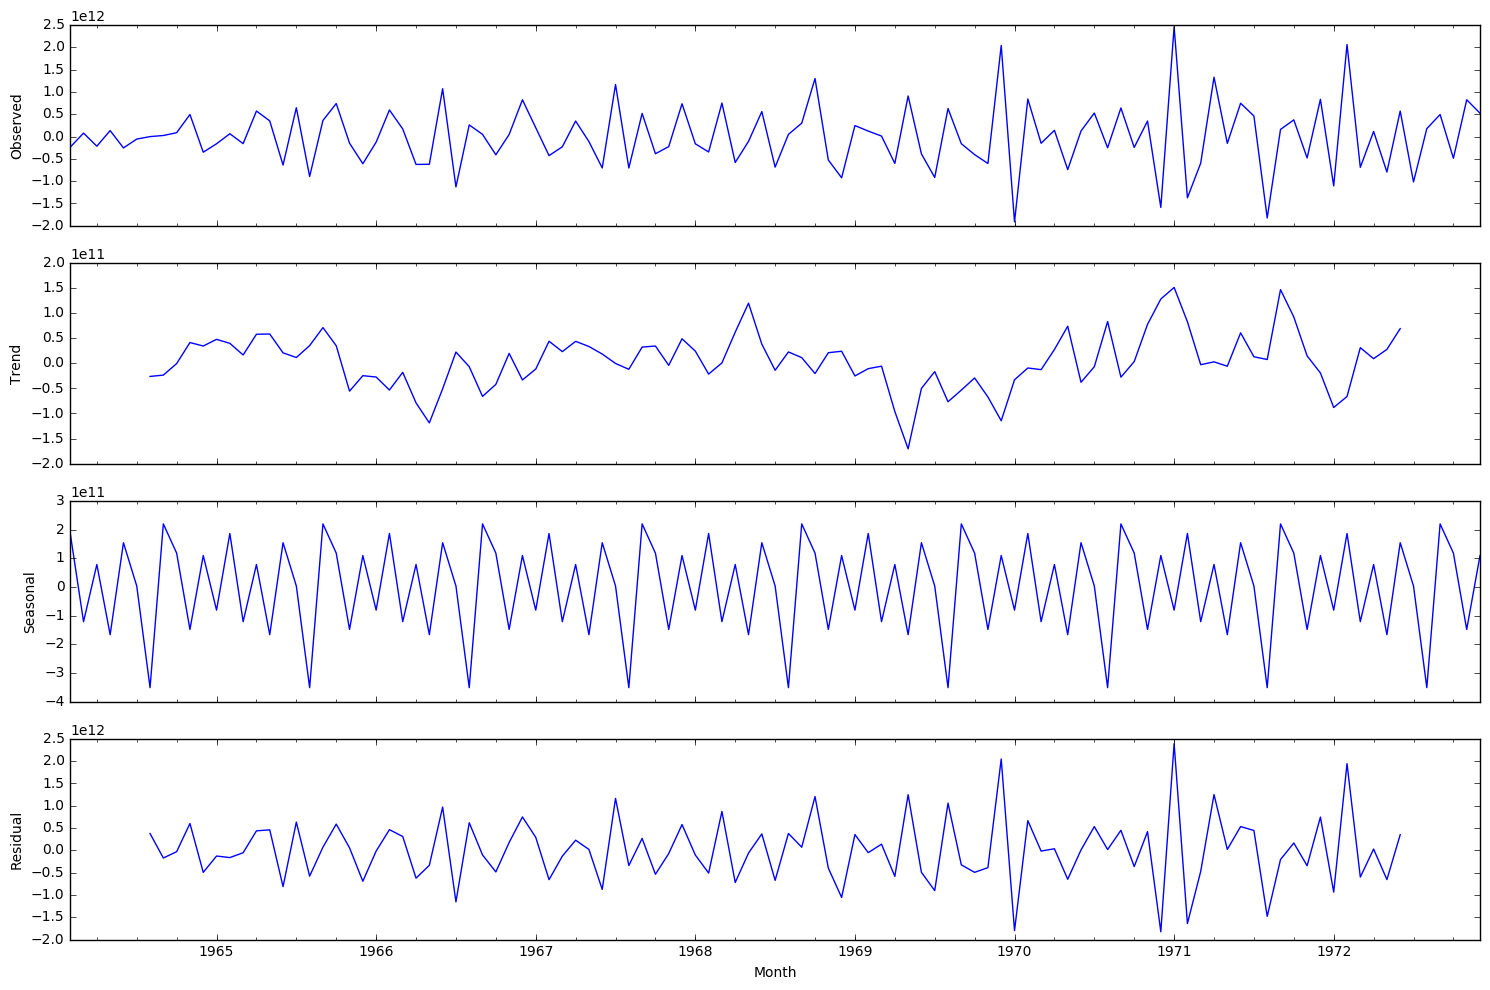

In [6]:
paper_sales_data['sales_box_diff2'] = paper_sales_data.sales_box_diff - paper_sales_data.sales_box_diff.shift(1)
plt.figure(figsize(15,10))
sm.tsa.seasonal_decompose(paper_sales_data.sales_box_diff2[13:]).plot()   
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(paper_sales_data.sales_box_diff2[13:])[1])

Гипотеза нестационарности отвергается, и визуально ряд выглядит лучше — тренда больше нет. 

## Подбор модели

Посмотрим на ACF и PACF полученного ряда:

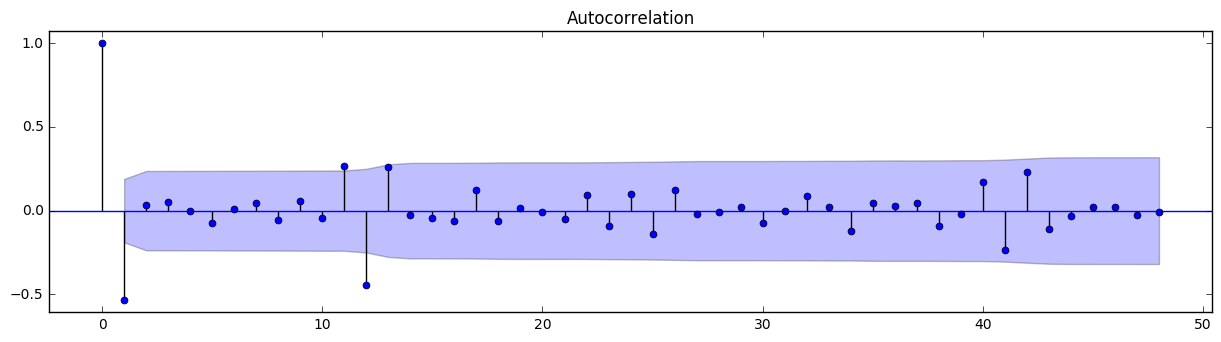

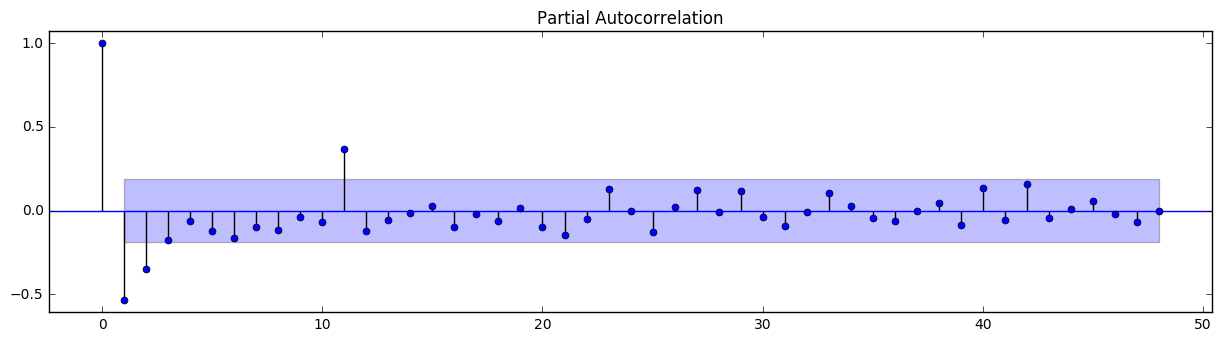

In [7]:
plt.figure(figsize(15,8))
ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(paper_sales_data.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()
ax = plt.subplot(212)
sm.graphics.tsa.plot_pacf(paper_sales_data.sales_box_diff2[13:].values.squeeze(), lags=48, ax=ax)
pylab.show()

Начальные приближения: Q=1, q=2, P=1, p=4

In [8]:
ps = range(0, 5)
d=1
qs = range(0, 3)
Ps = range(0, 2)
D=1
Qs = range(0, 2)

In [9]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

60

In [10]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(paper_sales_data.sales_box, order=(param[0], d, param[1]), 
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
warnings.filterwarnings('default')

wrong parameters: (0, 0, 0, 0)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong parameters: (2, 2, 1, 0)
wrong parameters: (2, 2, 1, 1)
wrong parameters: (3, 2, 0, 0)
wrong parameters: (3, 2, 0, 1)
wrong parameters: (3, 2, 1, 0)
wrong parameters: (3, 2, 1, 1)
wrong parameters: (4, 2, 0, 0)
wrong parameters: (4, 2, 0, 1)
wrong parameters: (4, 2, 1, 0)
wrong parameters: (4, 2, 1, 1)
CPU times: user 23.7 s, sys: 674 ms, total: 24.3 s
Wall time: 15.8 s


In [11]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
4   (0, 1, 0, 1)  6088.286606
5   (0, 1, 1, 0)  6088.700544
6   (0, 1, 1, 1)  6089.331640
16  (1, 1, 0, 1)  6090.122228
8   (0, 2, 0, 1)  6090.399756


Лучшая модель:

In [12]:
print(best_model.summary())

                                 Statespace Model Results                                 
Dep. Variable:                          sales_box   No. Observations:                  120
Model:             SARIMAX(0, 1, 1)x(0, 1, 1, 12)   Log Likelihood               -3041.143
Date:                            Fri, 16 Dec 2016   AIC                           6088.287
Time:                                    21:22:57   BIC                           6096.649
Sample:                                01-01-1963   HQIC                          6091.683
                                     - 12-01-1972                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.7159      0.077     -9.266      0.000      -0.867      -0.564
ma.S.L12      -0.4077      0.110   

Её остатки:

Критерий Стьюдента: p=0.449955
Критерий Дики-Фуллера: p=0.000000


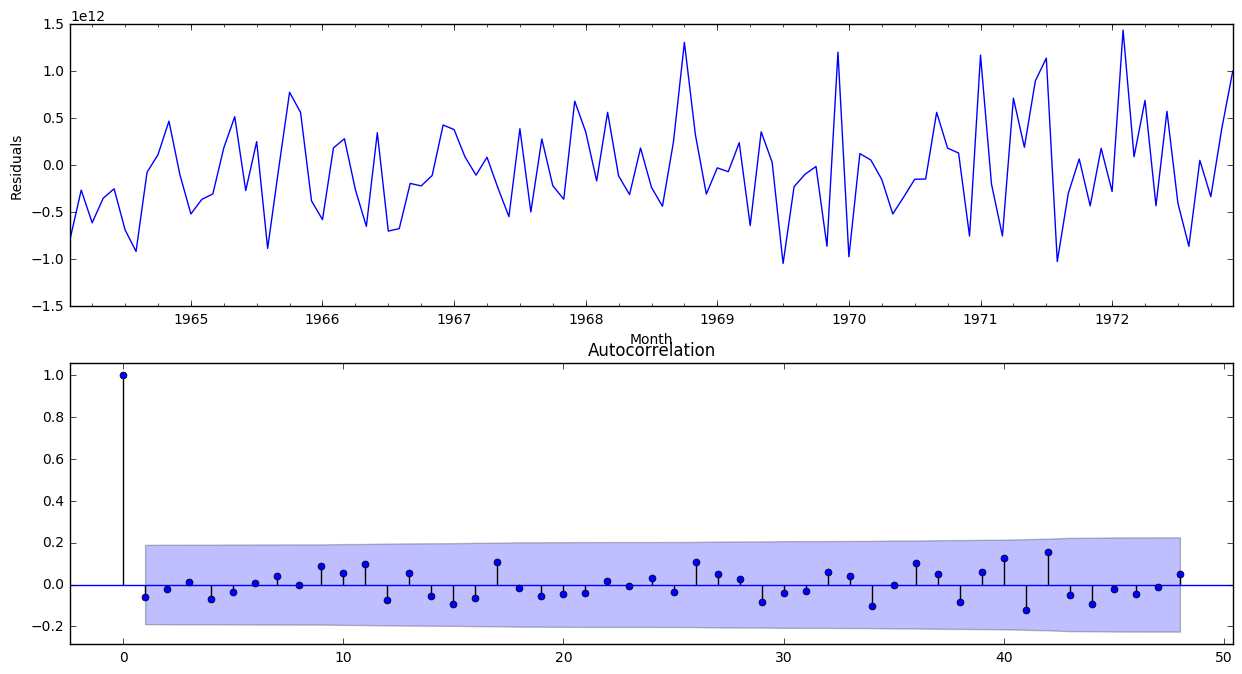

In [13]:
plt.figure(figsize(15,8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p=%f" % stats.ttest_1samp(best_model.resid[13:], 0)[1])
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой).
Посмотрим, насколько хорошо модель описывает данные:

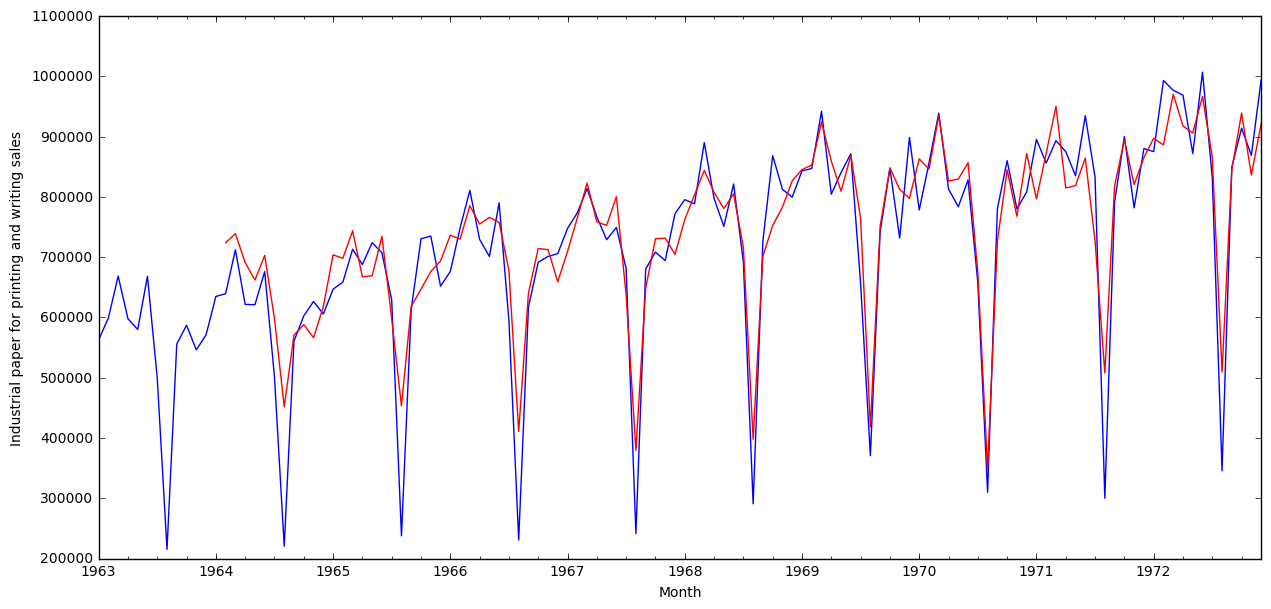

In [14]:
paper_sales_data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15,7))
paper_sales_data.sales.plot()
paper_sales_data.model[13:].plot(color='r')
plt.ylabel('Industrial paper for printing and writing sales')
pylab.show()

### Прогноз

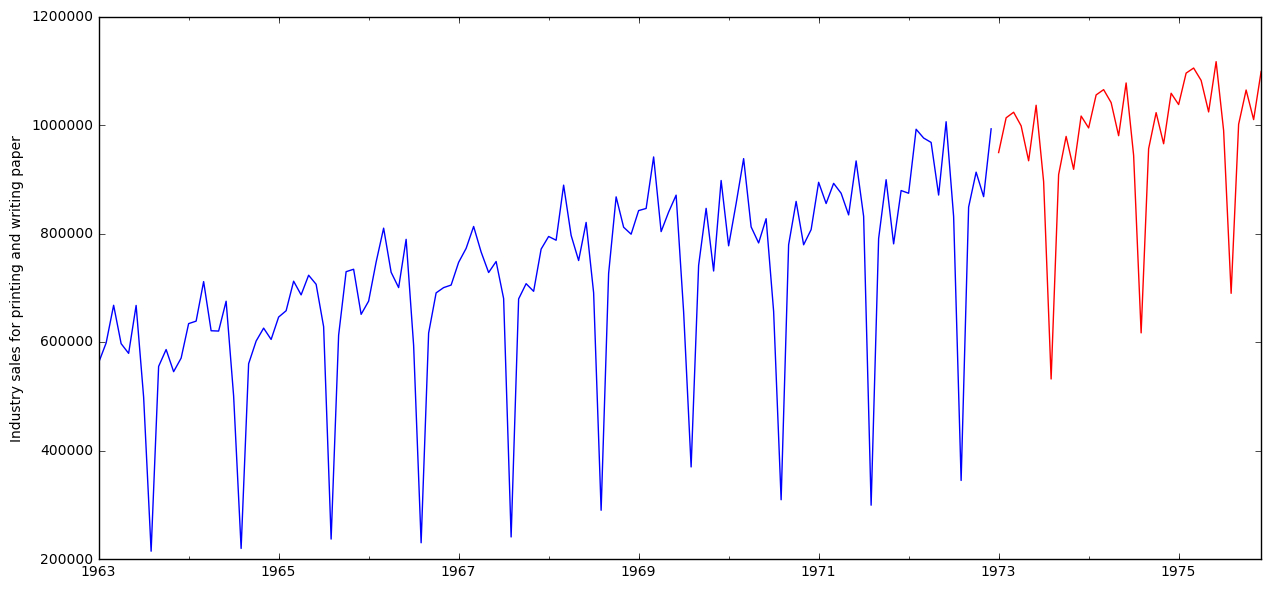

In [52]:
paper_sales_data2 = paper_sales_data[['sales']]
date_list = [datetime.datetime.strptime("1973-01", "%Y-%m") + relativedelta(months=x) for x in range(0,36)]
future = pd.DataFrame(index=date_list, columns= paper_sales_data2.columns)
paper_sales_data2 = pd.concat([paper_sales_data2, future])
paper_sales_data2['forecast'] = invboxcox(best_model.predict(start=120, end=156), lmbda)

plt.figure(figsize(15,7))
paper_sales_data2.sales.plot()
paper_sales_data2.forecast.plot(color='r')
plt.ylabel('Industry sales for printing and writing paper')
pylab.show()